In [ ]:
!pip install imbalanced-learn

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# 3. Baca dataset
df = pd.read_csv('/content/drive/MyDrive/Tugas ML/diabetes.csv')

# 4. Ambil hanya 4 fitur penting
selected_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'Outcome']
df = df[selected_features]

Mounted at /content/drive


In [ ]:
# 5. Nilai 0 jadi NaN untuk fitur tertentu
for col in ['Glucose', 'BMI', 'Insulin']:
    df[col] = df[col].replace(0, np.nan)

# 6. Imputasi nilai NaN dengan median
imputer = SimpleImputer(strategy='median')
df[['Glucose', 'BMI', 'Insulin']] = imputer.fit_transform(df[['Glucose', 'BMI', 'Insulin']])

# 7. Pisahkan fitur dan label
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [ ]:
# 8. Split data train/test (sebelum normalisasi dan oversampling agar tidak ada data leak)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 9. Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# 10. Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)

In [ ]:
# 11. Grid Search untuk tuning hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 250, 500],
    'max_depth': [2, 4, 5, 10],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5, 7, 10]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring='f1',  # Bisa diganti 'recall' untuk fokus turunkan FN
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y_train)

# Ambil model terbaik dari hasil pencarian
model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# 12. Evaluasi pada data test
y_pred = model.predict(X_scaled_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Negatif", "Positif"]))
print("Akurasi:", accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.78      0.85      0.82       150
     Positif       0.67      0.56      0.61        81

    accuracy                           0.75       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.74      0.75      0.74       231

Akurasi: 0.7489177489177489


In [ ]:
# Cek overfit
y_train_pred = model.predict(X_scaled)
print("\n=== Classification Report (Train) ===")
print(classification_report(y_train, y_train_pred, target_names=["Negatif", "Positif"]))
print("Akurasi (Train):", accuracy_score(y_train, y_train_pred))


=== Classification Report (Train) ===
              precision    recall  f1-score   support

     Negatif       0.87      0.93      0.90       350
     Positif       0.84      0.74      0.79       187

    accuracy                           0.86       537
   macro avg       0.86      0.83      0.84       537
weighted avg       0.86      0.86      0.86       537

Akurasi (Train): 0.8621973929236499


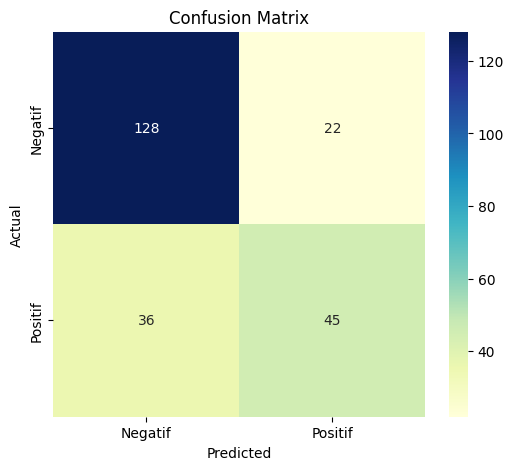

In [ ]:
# 11. Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='YlGnBu', xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()